In [1]:
import json
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from GHCND import *

2023-03-13 12:25:04.772501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 12:25:05.276732: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 12:25:05.452915: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 12:25:05.452958: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [ ]:
# split data into train, validate and test
# get data into correct shape (double check!!!)
# normalisation - scale to be between -1 and 1 (divide by max?)
# train and validate model
# test on input

In [2]:
f = open('data/stat_counts_tmax.txt')
data = json.load(f)

# find all stations with no data gaps
no_gaps_tmax = [k for k, v in data.items() if v == 0]
station = no_gaps_tmax[-1]
print(station)

USW00094823


### Get data, and shape train, validate and test arrays

Read 219 countries and codes
Read 991 stations with justGSN
Filename: USW00094823.dly
url name: http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/USW00094823.dly
destination: data/USW00094823.dly
USW00094823 is PITTSBURGH INTL AP, United States at 40.4847 -80.2144 366.7


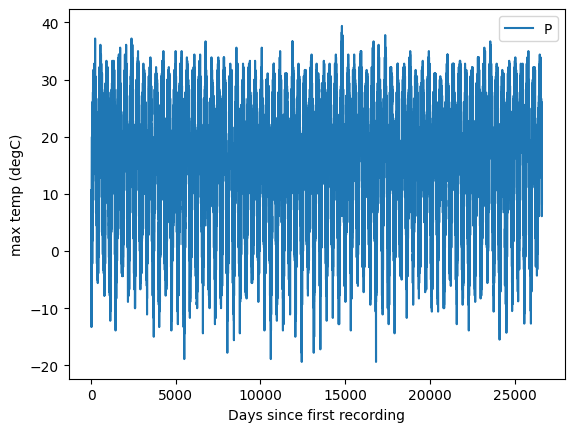

In [3]:
ghn = GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

# Get list of station names
station_names = ghn.getStatKeyNames()

# get url for a given station index
fileName = f"{station}.dly"
print(f"Filename: {fileName}")
urlName = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/{fileName}"
print(f"url name: {urlName}")

# copy station data from remote to local
destination = f"data/{fileName}"
print(f"destination: {destination}")
urllib.request.urlretrieve(urlName, destination)
station_data = ghn.processFile(destination)
print(ghn.getStation(station))

t_max = Variable(ghn.getVar(station_data, 'TMAX'), "max temp (degC)", ghn.stationDict[station].name)
t_max.convert_time()

fig, ax = plt.subplots()
ax.plot(t_max.get_dates(), t_max.get_vals())
ax.set_xlabel("Days since first recording")
ax.set_ylabel(f"{t_max.get_label()}")
ax.legend((t_max.get_station()))

In [4]:
vals = t_max.get_vals()
window_size = 10
offset = 1

# reshape data into input windows and targets
input, target = shapeArray(vals, window_size, offset)
print(f"Vals shape: {np.shape(vals)}")
print(f"Input shape: {np.shape(input)}")
print(f"Target shape: {np.shape(target)}")

# divide reshaoed data into training, vaildation and testing data
train_len = int(len(input) * 0.7)
validate_len = int(len(input) * 0.2)
test_len = int(len(input) * 0.1)

input_train = input[:train_len]
input_validate = input[train_len+1:train_len+validate_len]
input_test = input[train_len+validate_len+1:]

target_train = target[:train_len]
target_validate = target[train_len+1:train_len+validate_len]
target_test = target[train_len+validate_len+1:]

print(f"Training input shape: {np.shape(input_train)}")
print(input_train[0:4])
print(f"Training target shape: {np.shape(target_train)}")
print(target_train[0:4])


Vals shape: (26617,)
Input shape: (26607, 10)
Target shape: (26607, 1)
Training input shape: (18624, 10)
[[10.6  7.8  0.   3.9  1.1  0.  -2.2  6.1 10.6 -0.6]
 [ 7.8  0.   3.9  1.1  0.  -2.2  6.1 10.6 -0.6  2.2]
 [ 0.   3.9  1.1  0.  -2.2  6.1 10.6 -0.6  2.2  1.7]
 [ 3.9  1.1  0.  -2.2  6.1 10.6 -0.6  2.2  1.7  1.1]]
Training target shape: (18624, 1)
[[ 2.2]
 [ 1.7]
 [ 1.1]
 [-5.6]]


In [ ]:
model = keras.models.Sequential()
model.add(layers.LSTM(64, input_shape = (None, 1), return_sequences = True)) # LSTM layer with 50 neurons
model.add(layers.LSTM(16, activation = 'linear', return_sequences = True))
model.add(layers.LSTM(4, activation = 'linear', return_sequences = False))
model.add(layers.Dense(128, activation = "linear"))
model.add(layers.Dense(1, activation = "linear"))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.summary()

# train model and extract final loss
history = model.fit(input_train, target_train, epochs = 30)
cost = history.history['loss']

### Least mean-squared

Sum of the squared errors.

In [6]:
fake_lms = weather_fake_loss(vals)
print(fake_lms)


597596.0100000581


The fake lms, i.e. assuming that the weather the next day will be the same as the one before, is 30,000 times greater than the loss achieved by the RNN.